In [2]:
import os
import tensorflow as tf
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

In [11]:
text_file = open("./assets/list_promis.txt", "r")
query_array = text_file.read().split(',\n')
print(query_array)

['LewisHamilton', 'SebastianVettel', 'MaxVerstappen', 'KarlLauterbach', 'CristianoRonaldo', 'LionelMessi', 'EdSheeran', 'TomCruise', 'HeleneFischer', 'ArnoldSchwarzenegger', 'GüntherJauch', 'StefanRaab', 'HeidiKlum', 'ManuelNeuer', "ElyasM'barek", 'JudithRakers', 'AngelaMerkel', 'WladimirPutin', 'OlafScholz', 'JoeBiden', 'DonaldTrump', 'ChristianLindner', 'AnnalenaBaerbock', 'ElonMusk', 'JeffBezos', 'BarackObama', 'ChrisPratt', 'XiJinping', 'DwayneJohnson', 'MacKenzieScott', 'AnthonyFauci', 'GeorgeClooney', 'BradPitt', 'KobeBryant', "ShaquilleO'Neal", 'VinDiesel', 'JasonMomoa', 'ChrisHemsworth', 'TomHiddleston', 'BenedictCumberbatch', 'ChadwickBoseman', 'LeBronJames', 'MichaelJordan', 'MichaelJackson', 'LeonardoDiCaprio', 'TomHanks', 'WillSmith', 'DenzelWashington', 'RobertDowneyJr', 'TomHardy', 'MorganFreeman', 'NovakDjokovic', 'RafaelNadal', 'RogerFederer', 'ChristianBale', 'SylvesterStallone']


In [12]:
print(os.getcwd())

path = os.getcwd()
abspath = os.path.abspath(os.path.join(path, os.pardir))

datapath = abspath + "/datasetV2/"

chosen_tf_model_folder = 'TF_V2';  # entry which model you want to test (different versions)

outpath =  f'{abspath}/models/{chosen_tf_model_folder}/'

/tf/src/scripts


In [13]:
def read_train_val_test(dataset_dir, label_map):
    return tuple(map(lambda set_: object_detector.DataLoader.from_pascal_voc(images_dir=os.path.join(dataset_dir, set_), annotations_dir=os.path.join(dataset_dir, set_), label_map=label_map), ("train", "val", "test")))

In [14]:
labelmap = query_array
train_data, validation_data, test_data = read_train_val_test(datapath, labelmap)

INFO:tensorflow:Cache will be stored in /tmp/tmpvga9vtd5 with prefix filename 7bee435cfee6949ada7cad38d32e815e. Cache_prefix is /tmp/tmpvga9vtd5/7bee435cfee6949ada7cad38d32e815e
INFO:tensorflow:On image 0
INFO:tensorflow:On image 100
INFO:tensorflow:On image 200
INFO:tensorflow:On image 300
INFO:tensorflow:On image 400
INFO:tensorflow:On image 500
INFO:tensorflow:On image 600
INFO:tensorflow:On image 700
INFO:tensorflow:On image 800
INFO:tensorflow:On image 900
INFO:tensorflow:On image 1000
INFO:tensorflow:On image 1100
INFO:tensorflow:On image 1200
INFO:tensorflow:On image 1300
INFO:tensorflow:On image 1400
INFO:tensorflow:On image 1500
INFO:tensorflow:On image 1600
INFO:tensorflow:On image 1700
INFO:tensorflow:On image 1800
INFO:tensorflow:On image 1900
INFO:tensorflow:On image 2000
INFO:tensorflow:On image 2100
INFO:tensorflow:On image 2200
INFO:tensorflow:On image 2300
INFO:tensorflow:On image 2400
INFO:tensorflow:On image 2500
INFO:tensorflow:On image 2600
INFO:tensorflow:On image

KeyboardInterrupt: 

In [15]:
import time

import cv2
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def to_json(self):
        return {
            "x": self.x,
            "y": self.y,
        }

    def __str__(self):
        return str(self.to_json())

class BoundingBox:
    def __init__(self, xmin, ymin, xmax, ymax):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.center = Point((xmin + xmax) // 2, (ymin + ymax) // 2)
        self.width = xmax - xmin
        self.height = ymax - ymin
        self.area = self.width * self.height

    def to_json(self):
        return {
            "xmin": self.xmin,
            "ymin": self.ymin,
            "xmax": self.xmax,
            "ymax": self.ymax,
        }

    def __str__(self):
        return str(self.to_json())

class Detection:
    def __init__(self, class_, confidence, xmin, ymin, xmax, ymax):
        self.class_ = class_
        self.confidence = confidence
        self.bounding_box = BoundingBox(xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax)

    def to_json(self):
        return {
            "class": self.class_,
            "confidence": self.confidence,
            "box": self.bounding_box.to_json(),
        }

    def __str__(self):
        return str(self.to_json())


class EfficientDetLite:
    def __init__(self, model_path, labelmap):
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.interpreter.allocate_tensors()

        # iti = input tensor index
        input_details = self.interpreter.get_input_details()
        self.iti_image = input_details[0]["index"]
        self.it_image_dtype = input_details[0]["dtype"]
        self.it_image_width = input_details[0]["shape"][2]
        self.it_image_height = input_details[0]["shape"][1]

        # oti = output tensor index
        output_details = self.interpreter.get_output_details()
        self.oti_bounding_boxes = output_details[1]["index"]
        self.oti_classes = output_details[3]["index"]
        self.oti_confidences = output_details[0]["index"]

        self.labelmap = labelmap

    def detect(self, image, threshold=0):
        input_tensor = self.prepare_image(image)
        self.interpreter.set_tensor(self.iti_image, input_tensor)
        self.interpreter.invoke()

        bounding_boxes = self.interpreter.get_tensor(self.oti_bounding_boxes)[0]
        classes = self.interpreter.get_tensor(self.oti_classes)[0]
        confidences = self.interpreter.get_tensor(self.oti_confidences)[0]
        detections = zip(classes, bounding_boxes, confidences)
        detections = filter(lambda x: x[2] >= threshold, detections)

        def tensors2detection(x):
            def clamp(n, min_, max_):
                return max(min(max_, n), min_)

            xmin = clamp(int(round(x[1][1] * image.shape[1])), 0, image.shape[1])
            ymin = clamp(int(round(x[1][0] * image.shape[0])), 0, image.shape[0])
            xmax = clamp(int(round(x[1][3] * image.shape[1])), 0, image.shape[1])
            ymax = clamp(int(round(x[1][2] * image.shape[0])), 0, image.shape[0])
            name = str(self.labelmap[int(x[0])])
            confidence = float(x[2])

            detection = Detection(name, confidence, xmin, ymin, xmax, ymax)
            return detection

        detections = map(lambda x: tensors2detection(x), detections)
        detections = list(detections)
        return detections

    def prepare_image(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.it_image_width, self.it_image_height), interpolation=cv2.INTER_NEAREST)
        tensor = np.reshape(image, (1, self.it_image_height, self.it_image_width, 3))
        tensor = tensor.astype(self.it_image_dtype)
        return tensor

def show_image(image, label=None, scale=1):
    show_images([image], labels=[label] if label is not None else None, scale=scale)


def show_images(images, labels=None, scale=1):
    figsize = plt.rcParams["figure.figsize"]
    plt.figure(figsize=(figsize[0] * scale, figsize[1] * scale))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        plt.imshow(image, cmap=plt.cm.binary)
        if labels is not None:
            plt.xlabel(labels[i])
    plt.show()


def show_detection(image, detection, scale=1, thickness=1, colors=None, confidence=True):
    show_image(draw_detections(image,
                               [detection],
                               scale=scale,
                               thickness=thickness,
                               colors=colors,
                               confidence=confidence))


def show_detections(image, detections, scale=1, thickness=1, colors=None, confidence=True):
    show_image(draw_detections(image,
                               detections,
                               scale=scale,
                               thickness=thickness,
                               colors=colors,
                               confidence=confidence))


def draw_detection(image, detection, scale=1, thickness=1, colors=None, confidence=True):
    return draw_detections(image, [detection], scale, thickness, colors, confidence)


def draw_detections(image, detections, scale=1, thickness=1, colors=None, confidence=True):
    colors = {} if colors is None else {k: tuple(reversed(v)) for k, v in colors.items()}
    result = image.copy()
    for detection in detections:
        xmin = int(detection.bounding_box.xmin)
        ymin = int(detection.bounding_box.ymin)
        xmax = int(detection.bounding_box.xmax)
        ymax = int(detection.bounding_box.ymax)
        color = colors.get(detection.class_)
        if color is None:
            color = (206, 255, 0)
        result = cv2.rectangle(result, (xmin, ymin), (xmax, ymax), color, thickness)
        if confidence:
            text = "{:.2f}".format(float(detection.confidence))
            font = cv2.FONT_HERSHEY_SIMPLEX
            textsize = cv2.getTextSize(text, font, scale, thickness)[0]
            result = cv2.putText(result,
                                 text,
                                 (
                                     ((xmin + xmax) - textsize[0]) // 2,
                                     ((ymin + ymax) + textsize[1]) // 2
                                 ),
                                 font,
                                 scale,
                                 color,
                                 thickness,
                                 cv2.LINE_AA)
    return result

In [16]:
model = EfficientDetLite(outpath + 'model.tflite', labelmap)

[[[ 77 110 255]
  [ 74 107 254]
  [ 70 102 251]
  ...
  [254 225 156]
  [255 230 161]
  [255 230 161]]

 [[ 77 110 255]
  [ 74 107 254]
  [ 70 102 251]
  ...
  [254 225 156]
  [255 228 159]
  [255 228 159]]

 [[ 76 109 255]
  [ 73 106 253]
  [ 69 101 250]
  ...
  [248 219 150]
  [254 225 156]
  [254 225 156]]

 ...

 [[137 190 223]
  [136 189 222]
  [132 185 218]
  ...
  [144 202 221]
  [145 204 220]
  [144 203 219]]

 [[138 191 224]
  [138 191 224]
  [133 186 219]
  ...
  [148 204 223]
  [145 201 220]
  [144 200 219]]

 [[139 192 225]
  [139 192 225]
  [134 187 220]
  ...
  [150 206 225]
  [143 199 218]
  [142 198 217]]]
{'class': 'AngelaMerkel', 'confidence': 0.84765625, 'box': {'xmin': 166, 'ymin': 96, 'xmax': 355, 'ymax': 331}}


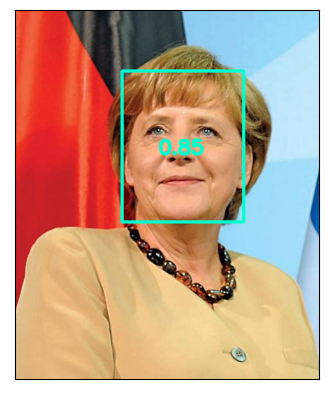

In [152]:
image = cv2.imread(datapath + 'test/012_cc66d81f.jpg') # change to exisiting image

print(image)

detections = model.detect(image, threshold=0.5)

for detection in detections:
  print(detection)

show_detections(image, detections, thickness=4)

In [7]:
import cv2

In [4]:
import os
import ffmpeg
import numpy as np
path = os.getcwd()
abspath = os.path.abspath(os.path.join(path, os.pardir))

inputPath = f'{abspath}/ffmpegTest/'
print(inputPath)

in_filename = inputPath + 'merkel2.mp4'
out_path = inputPath + 'frames/'
overlay_filename = inputPath + 'pic.png'

/tf/src/ffmpegTest/


In [154]:
probe = ffmpeg.probe(in_filename)
time = float(probe['streams'][0]['duration']) // 2
width = probe['streams'][0]['width']

In [155]:
parts = 10 #todo

In [156]:
intervals = time // parts
intervals = int(intervals)
interval_list = [(i * intervals, (i + 1) * intervals) for i in range(parts)]
i = 0

{'class': 'AngelaMerkel', 'confidence': 0.88671875, 'box': {'xmin': 2, 'ymin': 0, 'xmax': 478, 'ymax': 480}}


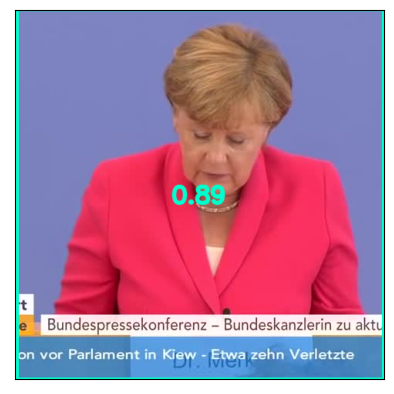

{'class': 'AngelaMerkel', 'confidence': 0.875, 'box': {'xmin': 2, 'ymin': 0, 'xmax': 478, 'ymax': 480}}


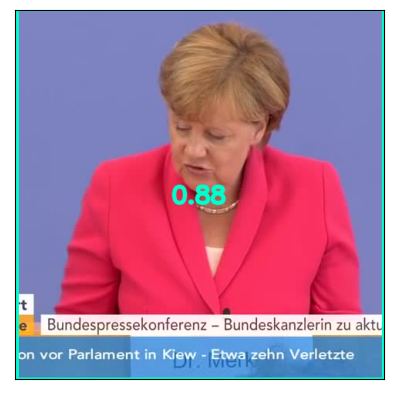

{'class': 'AngelaMerkel', 'confidence': 0.69140625, 'box': {'xmin': 214, 'ymin': 53, 'xmax': 353, 'ymax': 193}}


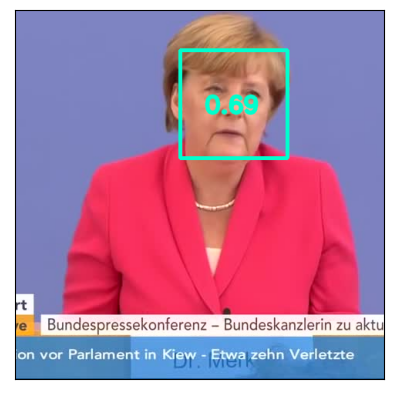

{'class': 'AngelaMerkel', 'confidence': 0.734375, 'box': {'xmin': 221, 'ymin': 53, 'xmax': 361, 'ymax': 191}}


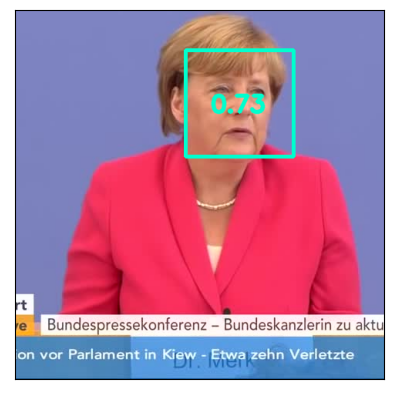

{'class': 'AngelaMerkel', 'confidence': 0.734375, 'box': {'xmin': 220, 'ymin': 56, 'xmax': 356, 'ymax': 195}}


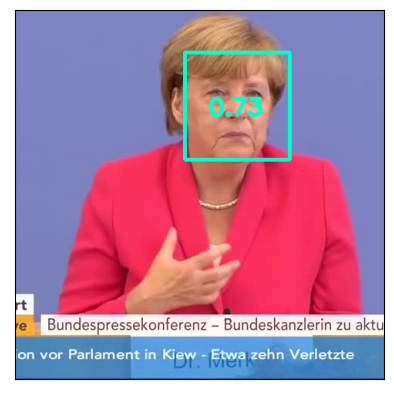

{'class': 'AngelaMerkel', 'confidence': 0.734375, 'box': {'xmin': 212, 'ymin': 58, 'xmax': 354, 'ymax': 198}}


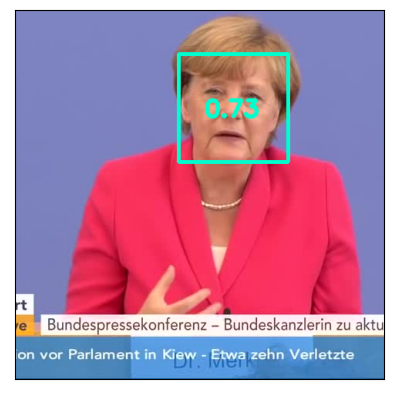

{'class': 'AngelaMerkel', 'confidence': 0.71484375, 'box': {'xmin': 190, 'ymin': 55, 'xmax': 332, 'ymax': 197}}


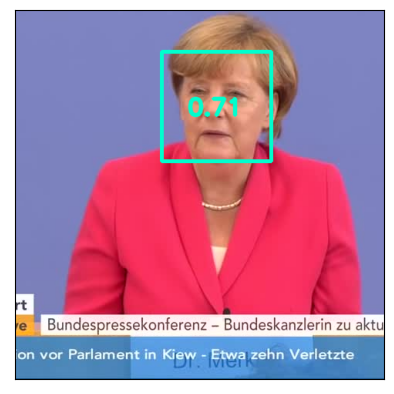

{'class': 'AngelaMerkel', 'confidence': 0.71484375, 'box': {'xmin': 190, 'ymin': 58, 'xmax': 329, 'ymax': 198}}


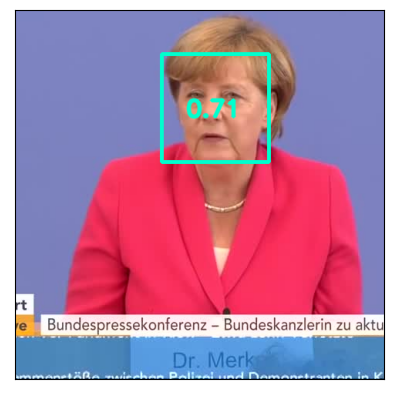

{'class': 'AngelaMerkel', 'confidence': 0.61328125, 'box': {'xmin': 234, 'ymin': 53, 'xmax': 369, 'ymax': 188}}


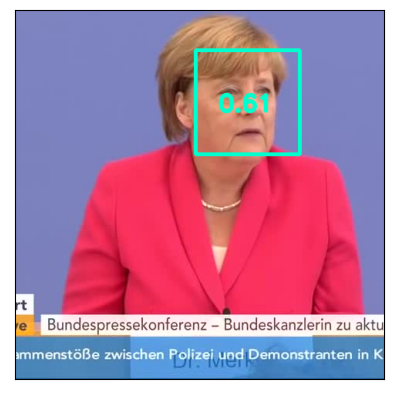

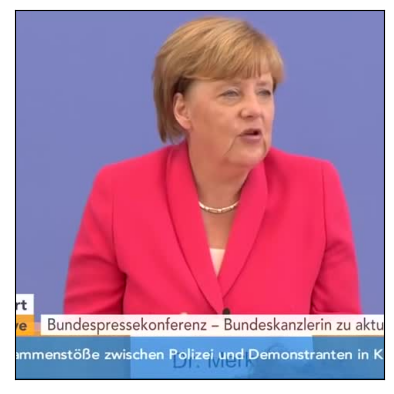

In [159]:
for item in interval_list:
    (
        ffmpeg
        .input(in_filename, ss=item[1])
        .filter('scale', width, -1)
        .output(out_path + '/frame' + str(i) + '.jpg', vframes=1)
        .run()
    )
    
    
    image = cv2.imread(out_path + '/frame' + str(i) + '.jpg')
    
    h,w,d = image.shape
    idk = (w - h)//2
    image = image[:,idk:w-idk,:]
    
    detections = model.detect(image, threshold=0.6)
    for detection in detections:
        print(detection)
    image = show_detections(image, detections, thickness=4)   
    
    i += 1
    
    
    
    
    

In [17]:
framePath = inputPath + '/frames/'
frameOutput = inputPath + '/framesOutput2/'

{'class': 'AngelaMerkel', 'confidence': 0.84765625, 'box': {'xmin': 2, 'ymin': 0, 'xmax': 478, 'ymax': 480}}


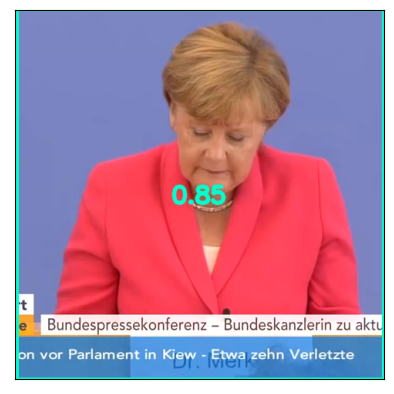

{'class': 'AngelaMerkel', 'confidence': 0.84765625, 'box': {'xmin': 2, 'ymin': 0, 'xmax': 478, 'ymax': 480}}


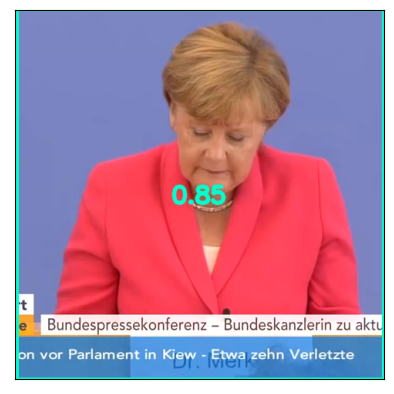

{'class': 'AngelaMerkel', 'confidence': 0.83203125, 'box': {'xmin': 2, 'ymin': 0, 'xmax': 478, 'ymax': 480}}


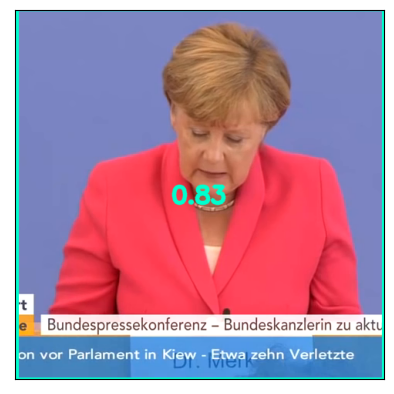

{'class': 'AngelaMerkel', 'confidence': 0.88671875, 'box': {'xmin': 0, 'ymin': 0, 'xmax': 480, 'ymax': 480}}


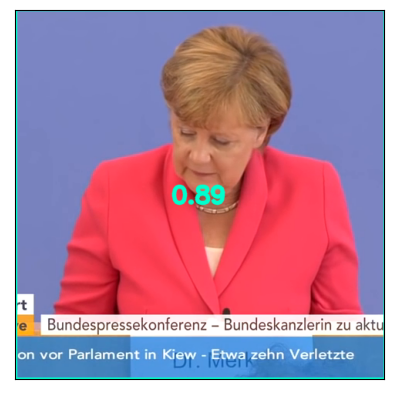

{'class': 'AngelaMerkel', 'confidence': 0.61328125, 'box': {'xmin': 3, 'ymin': 0, 'xmax': 477, 'ymax': 471}}


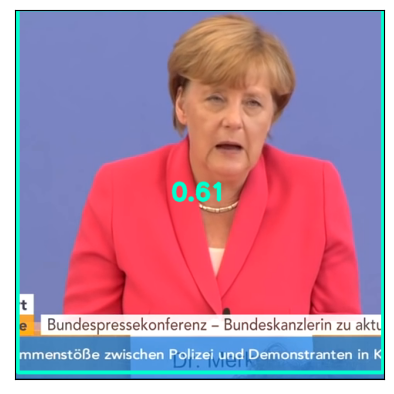

{'class': 'AngelaMerkel', 'confidence': 0.640625, 'box': {'xmin': 211, 'ymin': 66, 'xmax': 353, 'ymax': 208}}


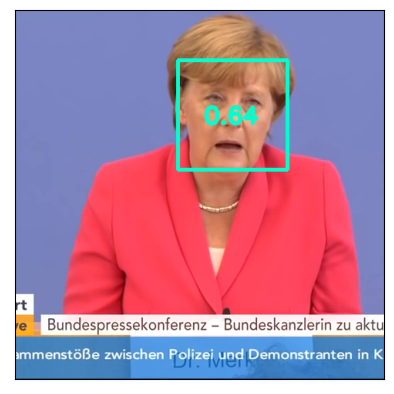

{'class': 'AngelaMerkel', 'confidence': 0.640625, 'box': {'xmin': 211, 'ymin': 66, 'xmax': 353, 'ymax': 208}}


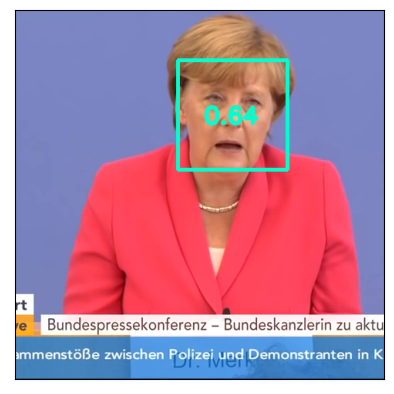

{'class': 'AngelaMerkel', 'confidence': 0.61328125, 'box': {'xmin': 210, 'ymin': 65, 'xmax': 354, 'ymax': 208}}


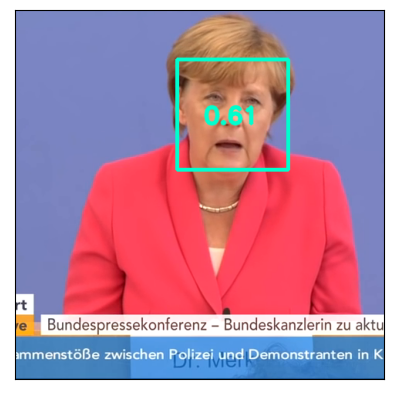

{'class': 'AngelaMerkel', 'confidence': 0.61328125, 'box': {'xmin': 210, 'ymin': 65, 'xmax': 354, 'ymax': 208}}


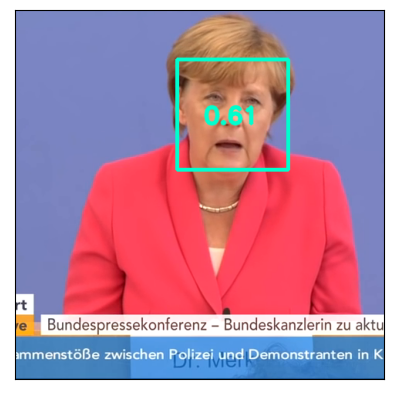

{'class': 'AngelaMerkel', 'confidence': 0.61328125, 'box': {'xmin': 210, 'ymin': 65, 'xmax': 354, 'ymax': 208}}


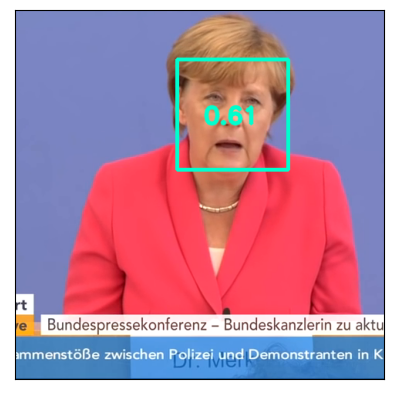

{'class': 'AngelaMerkel', 'confidence': 0.61328125, 'box': {'xmin': 211, 'ymin': 65, 'xmax': 353, 'ymax': 208}}


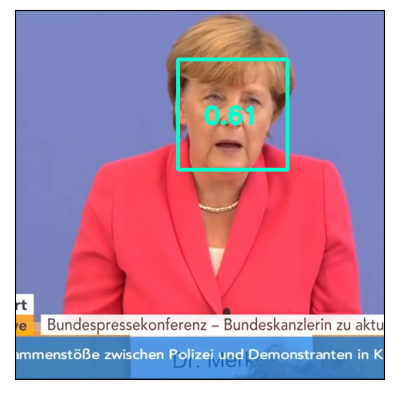

{'class': 'AngelaMerkel', 'confidence': 0.61328125, 'box': {'xmin': 211, 'ymin': 65, 'xmax': 353, 'ymax': 208}}


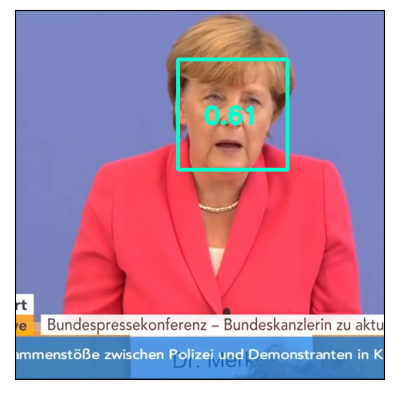

{'class': 'AngelaMerkel', 'confidence': 0.61328125, 'box': {'xmin': 209, 'ymin': 63, 'xmax': 355, 'ymax': 210}}


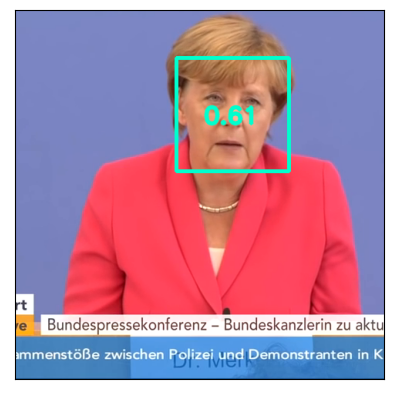

{'class': 'AngelaMerkel', 'confidence': 0.61328125, 'box': {'xmin': 209, 'ymin': 63, 'xmax': 355, 'ymax': 210}}


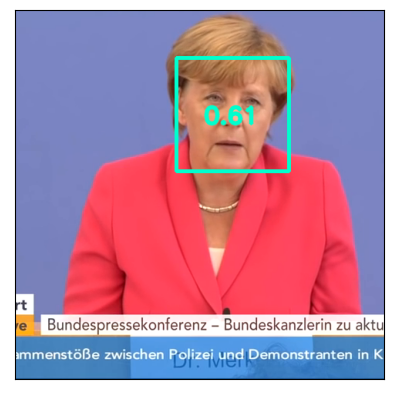

{'class': 'AngelaMerkel', 'confidence': 0.875, 'box': {'xmin': 0, 'ymin': 0, 'xmax': 480, 'ymax': 480}}


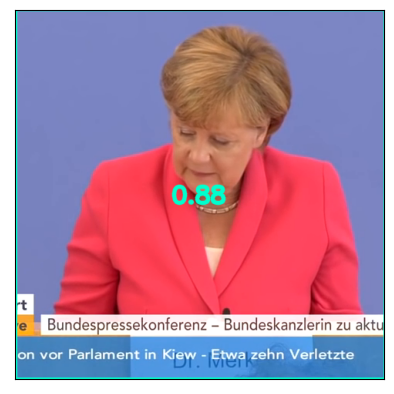

{'class': 'AngelaMerkel', 'confidence': 0.640625, 'box': {'xmin': 211, 'ymin': 65, 'xmax': 353, 'ymax': 207}}


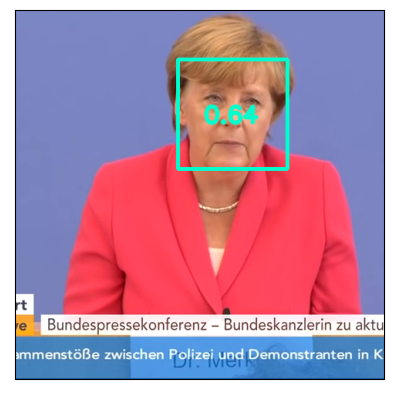

{'class': 'AngelaMerkel', 'confidence': 0.640625, 'box': {'xmin': 211, 'ymin': 65, 'xmax': 353, 'ymax': 207}}


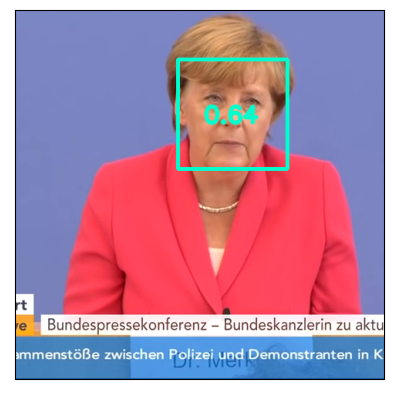

{'class': 'AngelaMerkel', 'confidence': 0.640625, 'box': {'xmin': 211, 'ymin': 65, 'xmax': 353, 'ymax': 207}}


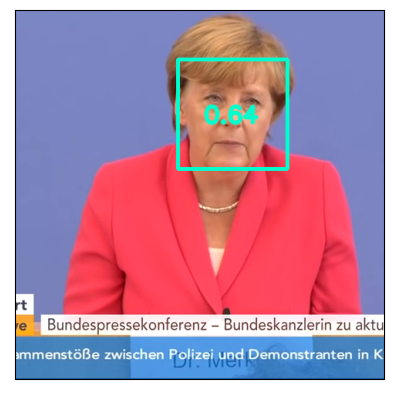

{'class': 'AngelaMerkel', 'confidence': 0.640625, 'box': {'xmin': 212, 'ymin': 65, 'xmax': 352, 'ymax': 207}}


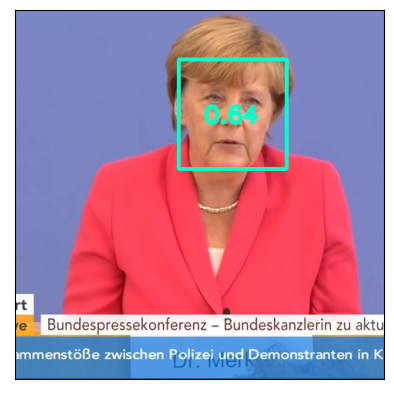

{'class': 'AngelaMerkel', 'confidence': 0.640625, 'box': {'xmin': 212, 'ymin': 65, 'xmax': 352, 'ymax': 207}}


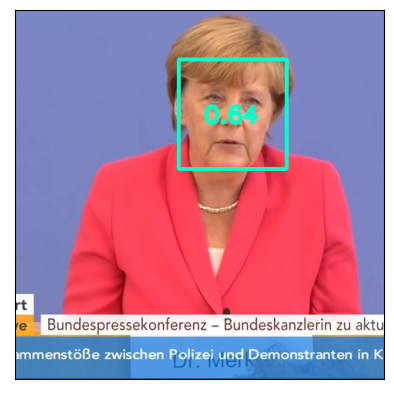

{'class': 'AngelaMerkel', 'confidence': 0.6640625, 'box': {'xmin': 212, 'ymin': 65, 'xmax': 352, 'ymax': 207}}


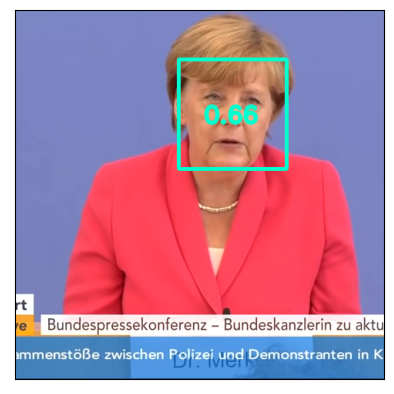

KeyboardInterrupt: 

In [18]:
frames = [f for f in os.listdir(framePath)]

for frame in frames:
    image = cv2.imread(framePath + frame)
    
    h,w,d = image.shape
    idk = (w - h)//2
    image = image[:,idk:w-idk,:]
    
    detections = model.detect(image, threshold=0.6)
    for detection in detections:
        print(detection)
    image = show_detections(image, detections, thickness=4)  